# Duplicate Analysis

In [7]:
from scripts.preprocess_data import *
from scripts.preprocess_lemmatizer import preprocess_lemmatizer
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
df = load_data()

In [9]:
print(f"""
      Tweets: {df.shape[0]}
      Unique tweets: {df['text'].nunique()} 
      Duplicates: {df[df['text'].duplicated(keep=False)].shape[0]}
      Unique duplicates: {df[df['text'].duplicated(keep=False)]['text'].nunique()}""")



      Tweets: 70260
      Unique tweets: 48177 
      Duplicates: 37885
      Unique duplicates: 15802


In [10]:
df_duplicates = df[df['text'].duplicated(keep=False)]
duplicate_groups = df_duplicates.groupby('text').size().reset_index(name='count').sort_values(by='count', ascending=False)

duplication_distribution = duplicate_groups['count'].value_counts().sort_index()
duplication_distribution  

count
2      11313
3       3330
4        830
5        224
6         55
7         23
8         26
130        1
Name: count, dtype: int64

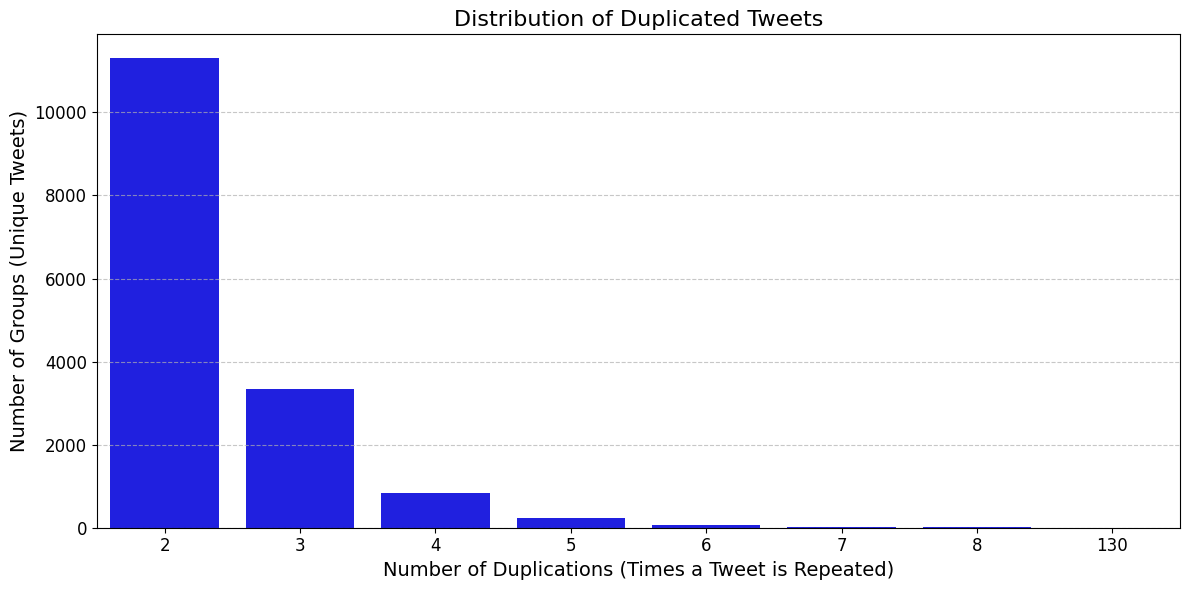

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(x=duplication_distribution.index, y=duplication_distribution.values, color='blue')

# Customize the plot
plt.title("Distribution of Duplicated Tweets", fontsize=16)
plt.xlabel("Number of Duplications (Times a Tweet is Repeated)", fontsize=14)
plt.ylabel("Number of Groups (Unique Tweets)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [31]:
filtered_duplicate_groups = duplicate_groups[duplicate_groups['count'] >= 5]
filtered_duplicate_groups.head()

,text,count
6397,Bring comfort dogs to every university lecture...,130
6163,Be mindful of your diet and exercise to stay h...,8
10327,Increase your website traffic for your home bu...,8
14905,Uncover the key strategies to boost your onlin...,8
12703,Reclaim your health and shed those unwanted fa...,8


In [29]:
df_duplicates['duplicate_count'] = df_duplicates.groupby('text')['text'].transform('count')
df_duplicates_unique = df_duplicates.drop_duplicates(subset='text')
df_duplicates_unique.shape

C:\Users\Simon.Luttmann\AppData\Local\Temp\ipykernel_17620\3982146916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicates['duplicate_count'] = df_duplicates.groupby('text')['text'].transform('count')


(15802, 6)